In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# --- CONFIG ---
csv_path = r'C:\Users\Jouke\Documents\evedata-logger\output\update_2025-07-13.csv'
fee_pct_buy = 0.005
fee_pct_sell = 0.005
tax_pct_sell = 0.0337
buy_rsi_thresh = 20
sell_rsi_thresh = 40
output_csv_path = 'rsi2_strategy_IS_top1000_iskflow.csv'
top_n = 1000

# --- LOAD DATA ---
df = pd.read_csv(csv_path)
df['date'] = pd.to_datetime(df['date'])

# --- Calculate average daily ISK flow per item ---
item_isk_flow = df.groupby('type_name').apply(
    lambda g: (g['average'] * g['volume']).mean()
).reset_index(name='avg_daily_isk_flow')

# --- Select top N items ---
top_items = item_isk_flow.sort_values('avg_daily_isk_flow', ascending=False).head(top_n)['type_name'].tolist()

print(f"Selected top {top_n} items by average daily ISK flow.")

# --- RSI-2 Calculation ---
def compute_rsi2(series):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=2).mean()
    avg_loss = pd.Series(loss).rolling(window=2).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# --- Strategy Function ---
def run_rsi2_strategy(df):
    df = df.copy()
    df = df.sort_values('date').reset_index(drop=True)
    df['rsi2'] = compute_rsi2(df['average'])
    df['rsi2_prev'] = df['rsi2'].shift(1)

    cash = 0
    position = 0
    buy_price = 0
    trade_rois = []
    trades = 0

    for idx, row in df.iterrows():
        if position == 0 and row['rsi2'] < buy_rsi_thresh and row['rsi2_prev'] >= buy_rsi_thresh:
            buy_price = row['average'] * (1 + fee_pct_buy)
            cash -= buy_price
            position = 1
            trades += 1
        elif position == 1 and row['rsi2'] > sell_rsi_thresh and row['rsi2_prev'] <= sell_rsi_thresh:
            sell_price = row['average'] * (1 - fee_pct_sell - tax_pct_sell)
            cash += sell_price
            trade_roi = (sell_price - buy_price) / buy_price
            trade_rois.append(trade_roi * 100)
            position = 0
            trades += 1

    if position == 1:
        last_price = df.iloc[-1]['average'] * (1 - fee_pct_sell - tax_pct_sell)
        cash += last_price
        trade_roi = (last_price - buy_price) / buy_price
        trade_rois.append(trade_roi * 100)
        trades += 1

    total_net_isk = cash
    avg_roi_per_trade = np.mean(trade_rois) if trade_rois else 0

    return trades, total_net_isk, avg_roi_per_trade

# --- Run on IS only with filtered top N items ---
results = []

for item in tqdm(top_items, desc='Processing Top ISK Flow Items'):
    sub_df = df[df['type_name'] == item].sort_values('date')
    if len(sub_df) < 30:
        continue
    is_end = int(len(sub_df) * 0.7)
    is_df = sub_df.iloc[:is_end]
    
    trades, net_isk, avg_roi = run_rsi2_strategy(is_df)
    results.append({
        'Item': item,
        'Trades': trades,
        'Net ISK': net_isk,
        'Avg ROI/Trade (%)': avg_roi
    })

# --- Save results ---
result_df = pd.DataFrame(results)
result_df.to_csv(output_csv_path, index=False)
print(f"RSI-2 IS strategy results saved to {output_csv_path}")

# --- Display top 20 results ---
display(result_df.sort_values('Net ISK', ascending=False).head(20))


Selected top 1000 items by average daily ISK flow.


C:\Users\Jouke\AppData\Local\Temp\ipykernel_3384\3505666638.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  item_isk_flow = df.groupby('type_name').apply(


Processing Top ISK Flow Items:   0%|          | 0/1000 [00:00<?, ?it/s]

RSI-2 IS strategy results saved to rsi2_strategy_IS_top1000_iskflow.csv


,Item,Trades,Net ISK,Avg ROI/Trade (%)
33,Cormack's Modified Damage Control,8,3.086556e+10,19381.818632
363,Men's Desert Nomad Mask,24,2.284558e+10,40.283679
314,CreoDron 'Yellowjacket' Drone Tuner D5-10T,8,2.240980e+10,23964.326641
170,Estamel's Modified Large Graviton Smartbomb,10,2.163194e+10,20056.422321
134,Unit P-343554's Modified Damage Control,18,1.597478e+10,19.285860
47,Cormack's Modified Large Plasma Smartbomb,8,1.591904e+10,57.718189
87,Unit W-634's Modified Drone Damage Amplifier,6,1.509444e+10,44.003127
62,Estamel's Modified Rapid Heavy Missile Launcher,8,1.503200e+10,39.853871
65,CONCORD Victory SKIN,38,1.430636e+10,11.740873
271,Gallente Victory SKIN,30,1.374171e+10,17.741654


In [7]:
import pandas as pd

# --- CONFIG ---
results_csv_path = r'C:\Users\Jouke\Documents\evedata-logger\output\rsi2_strategy_IS_top1000_iskflow.csv'

# --- LOAD RESULTS ---
df = pd.read_csv(results_csv_path)

# --- FILTER PROFITABLE ITEMS (Net ISK > 0) ---
profitable_after_fees = df[df['Net ISK'] > 0].reset_index(drop=True)

# --- SORT BY Avg ROI per Trade DESC ---
ranked = profitable_after_fees.sort_values('Avg ROI/Trade (%)', ascending=False).reset_index(drop=True)

# --- DISPLAY ---
display(ranked[['Item', 'Trades', 'Net ISK', 'Avg ROI/Trade (%)']])


,Item,Trades,Net ISK,Avg ROI/Trade (%)
0,CreoDron 'Yellowjacket' Drone Tuner D5-10T,8,2.240980e+10,23964.326641
1,Estamel's Modified Large Graviton Smartbomb,10,2.163194e+10,20056.422321
2,Cormack's Modified Damage Control,8,3.086556e+10,19381.818632
3,Estamel's Modified Cloaking Device,10,1.342001e+10,18926.084793
4,Sentient Fighter Support Unit,38,4.066572e+09,5012.423637
...,...,...,...,...
166,Compressed Zeolites,88,1.936628e+02,0.331451
167,Compressed Fullerite-C540,92,5.795520e+03,0.315005
168,Cataclysmic Gamma Filament,86,1.693067e+06,0.276331
169,Zero-Point Field Manipulator,80,1.981212e+04,0.233175


In [8]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# --- CONFIG ---
full_data_csv = r'C:\Users\Jouke\Documents\evedata-logger\output\update_2025-07-13.csv'
is_results_csv = r'C:\Users\Jouke\Documents\evedata-logger\output\rsi2_strategy_IS_top1000_iskflow.csv'
fee_pct_buy = 0.005
fee_pct_sell = 0.005
tax_pct_sell = 0.0337
buy_rsi_thresh = 20
sell_rsi_thresh = 40
output_oos_csv = r'C:\Users\Jouke\Documents\evedata-logger\output\rsi2_strategy_OOS_results.csv'

# --- LOAD DATA ---
full_df = pd.read_csv(full_data_csv)
full_df['date'] = pd.to_datetime(full_df['date'])

is_df = pd.read_csv(is_results_csv)
items_to_test = is_df['Item'].unique().tolist()

# --- RSI-2 Calculation ---
def compute_rsi2(series):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=2).mean()
    avg_loss = pd.Series(loss).rolling(window=2).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# --- Strategy Function ---
def run_rsi2_strategy(df):
    df = df.copy()
    df = df.sort_values('date').reset_index(drop=True)
    df['rsi2'] = compute_rsi2(df['average'])
    df['rsi2_prev'] = df['rsi2'].shift(1)

    cash = 0
    position = 0
    buy_price = 0
    trade_rois = []
    trades = 0

    for idx, row in df.iterrows():
        if position == 0 and row['rsi2'] < buy_rsi_thresh and row['rsi2_prev'] >= buy_rsi_thresh:
            buy_price = row['average'] * (1 + fee_pct_buy)
            cash -= buy_price
            position = 1
            trades += 1
        elif position == 1 and row['rsi2'] > sell_rsi_thresh and row['rsi2_prev'] <= sell_rsi_thresh:
            sell_price = row['average'] * (1 - fee_pct_sell - tax_pct_sell)
            cash += sell_price
            trade_roi = (sell_price - buy_price) / buy_price
            trade_rois.append(trade_roi * 100)
            position = 0
            trades += 1

    if position == 1:
        last_price = df.iloc[-1]['average'] * (1 - fee_pct_sell - tax_pct_sell)
        cash += last_price
        trade_roi = (last_price - buy_price) / buy_price
        trade_rois.append(trade_roi * 100)
        trades += 1

    total_net_isk = cash
    avg_roi_per_trade = np.mean(trade_rois) if trade_rois else 0

    return trades, total_net_isk, avg_roi_per_trade

# --- Run on OOS (last 30%) for filtered items ---
results_oos = []

for item in tqdm(items_to_test, desc='Processing OOS Items'):
    sub_df = full_df[full_df['type_name'] == item].sort_values('date')
    if len(sub_df) < 30:
        continue
    oos_start = int(len(sub_df) * 0.7)
    oos_df = sub_df.iloc[oos_start:]
    
    trades, net_isk, avg_roi = run_rsi2_strategy(oos_df)
    results_oos.append({
        'Item': item,
        'Trades': trades,
        'Net ISK': net_isk,
        'Avg ROI/Trade (%)': avg_roi
    })

# --- Save and display OOS results ---
result_oos_df = pd.DataFrame(results_oos)
result_oos_df.to_csv(output_oos_csv, index=False)
print(f"OOS RSI-2 strategy results saved to {output_oos_csv}")

display(result_oos_df.sort_values('Net ISK', ascending=False).head(20))


Processing OOS Items:   0%|          | 0/672 [00:00<?, ?it/s]

OOS RSI-2 strategy results saved to C:\Users\Jouke\Documents\evedata-logger\output\rsi2_strategy_OOS_results.csv


,Item,Trades,Net ISK,Avg ROI/Trade (%)
65,CONCORD Victory SKIN,16,1.213959e+10,18.625625
649,Rhea Mabebu Exchange SKIN,8,1.136266e+10,172.465507
38,Enhanced Neurolink Protection Cell,8,9.340919e+09,10.560357
119,Setele's Modified Damage Control,4,9.299127e+09,49.719693
47,Cormack's Modified Large Plasma Smartbomb,6,7.463273e+09,17.385128
136,Draclira's Modified Cap Recharger,8,7.405289e+09,16.060396
77,Genolution 'Auroral' AU-79,10,6.930207e+09,7.007076
122,Cormack's Modified 500MN Microwarpdrive,2,6.193333e+09,46.126650
271,Gallente Victory SKIN,10,5.926900e+09,19.506861
177,Estamel's Modified Cloaking Device,4,5.870873e+09,38.198750


In [11]:
import pandas as pd

# --- CONFIG ---
market_history_path = r'C:\Users\Jouke\Documents\evedata-logger\output\update_2025-07-13.csv'
candidate_items_path = r'C:\Users\Jouke\Documents\evedata-logger\output\rsi2_strategy_IS_top1000_iskflow.csv'
output_path = r'C:\Users\Jouke\Documents\evedata-logger\output\candidate_isk_flow_full.csv'

# --- Load data ---
market_df = pd.read_csv(market_history_path, parse_dates=['date'])
candidates_df = pd.read_csv(candidate_items_path)

candidate_items = set(candidates_df['Item'].unique())

# --- Filter to candidates ---
filtered_market = market_df[market_df['type_name'].isin(candidate_items)].copy()

# --- Compute average daily ISK flow per item ---
filtered_market['daily_isk_flow'] = filtered_market['average'] * filtered_market['volume']

avg_isk_flow = filtered_market.groupby('type_name')['daily_isk_flow'].mean().reset_index()
avg_isk_flow.rename(columns={'type_name': 'Item', 'daily_isk_flow': 'avg_daily_isk_flow'}, inplace=True)

# --- Save results ---
avg_isk_flow.to_csv(output_path, index=False)
print(f"Average daily ISK flow per candidate saved to {output_path}")


Average daily ISK flow per candidate saved to C:\Users\Jouke\Documents\evedata-logger\output\candidate_isk_flow_full.csv


In [13]:
import pandas as pd

# Load candidate ISK flow data
isk_flow_df = pd.read_csv(r'C:\Users\Jouke\Documents\evedata-logger\output\candidate_isk_flow_full.csv')

# Load filtered stable candidates OOS results
oos_results_df = pd.read_csv(r'C:\Users\Jouke\Documents\evedata-logger\output\rsi2_strategy_OOS_results.csv')

# Filter stable candidates
stable_candidates = oos_results_df[
    (oos_results_df['Net ISK'] > 0) &
    (oos_results_df['Avg ROI/Trade (%)'] > 1) &
    (oos_results_df['Trades'] >= 10)
]

# Merge with ISK flow
merged_final = pd.merge(
    stable_candidates, isk_flow_df,
    on='Item',
    how='left'
)

# Display or save results
print(merged_final.head(20))
merged_final.to_csv(r'C:\Users\Jouke\Documents\evedata-logger\output\stable_candidates_with_iskflow.csv', index=False)

# Assuming your merged DataFrame is named 'merged_final'

output_csv_path = r'C:\Users\Jouke\Documents\evedata-logger\output\stable_candidates_with_iskflow.csv'

merged_final.to_csv(output_csv_path, index=False)
print(f"Exported merged results to {output_csv_path}")


                                           Item  Trades       Net ISK  \
0                                     HyperCore      32  1.126954e+05   
1                    Tetrimonic Warclone Blanks      32  6.746645e+05   
2                          CONCORD Victory SKIN      16  1.213959e+10   
3                  Zero-Point Field Manipulator      28  8.749635e+04   
4                    Genolution 'Auroral' AU-79      10  6.930207e+09   
5         Dread Guristas Drone Damage Amplifier      44  2.436710e+07   
6               Zorya's Entropic Radiation Sink      16  2.046470e+09   
7                           Overseer Sabik Vial      34  3.976957e+05   
8       Men's "Crisis Breaker" Drifter Plugsuit      10  1.561990e+08   
9                 Breacher Pod Clone Efficacity      24  3.511761e+07   
10  Inherent Implants 'Highwall' Mining MX-1005      38  5.532107e+07   
11                      Breacher Pod Projection      26  6.249844e+07   
12                  High-grade Ascendancy Omega    

In [14]:
import pandas as pd
import numpy as np

# --- CONFIG ---
capital = 1_000_000_000  # 1 billion ISK starting capital
max_daily_alloc_pct = 0.1  # max 10% of daily ISK flow per item allowed

# --- Load your merged dataset ---
merged_df_path = r'C:\Users\Jouke\Documents\evedata-logger\output\stable_candidates_with_iskflow.csv'
df = pd.read_csv(merged_df_path)

# Filter out any with missing liquidity or zero/negative liquidity
df = df[df['avg_daily_isk_flow'] > 0].copy()

# --- Calculate a score: weighted combination of ROI and trades ---
# Normalize ROI and trades separately (min-max scaling)
df['roi_norm'] = (df['Avg ROI/Trade (%)'] - df['Avg ROI/Trade (%)'].min()) / (df['Avg ROI/Trade (%)'].max() - df['Avg ROI/Trade (%)'].min())
df['trades_norm'] = (df['Trades'] - df['Trades'].min()) / (df['Trades'].max() - df['Trades'].min())

# Combined score (weights can be adjusted)
df['score'] = 0.7 * df['roi_norm'] + 0.3 * df['trades_norm']

# Normalize score to sum to 1
df['score_weight'] = df['score'] / df['score'].sum()

# Calculate max capital allocatable per item based on liquidity
df['max_liquidity_cap'] = df['avg_daily_isk_flow'] * max_daily_alloc_pct

# Cap allocation by liquidity constraint
df['alloc_cap'] = df['score_weight'] * capital
df['final_alloc'] = df[['alloc_cap', 'max_liquidity_cap']].min(axis=1)

# Re-normalize final allocation to sum to capital
df['final_alloc_weight'] = df['final_alloc'] / df['final_alloc'].sum()
df['final_alloc_value'] = df['final_alloc_weight'] * capital

# Sort portfolio by final allocation descending
portfolio = df.sort_values('final_alloc_value', ascending=False)

# --- Output portfolio summary ---
portfolio_summary = portfolio[['Item', 'Trades', 'Avg ROI/Trade (%)', 'avg_daily_isk_flow', 'final_alloc_value', 'final_alloc_weight']]

# Display top 20 portfolio allocations
display(portfolio_summary.head(20))

# Save portfolio to CSV
output_portfolio_path = r'C:\Users\Jouke\Documents\evedata-logger\output\automated_portfolio.csv'
portfolio_summary.to_csv(output_portfolio_path, index=False)
print(f"Automated portfolio saved to {output_portfolio_path}")


,Item,Trades,Avg ROI/Trade (%),avg_daily_isk_flow,final_alloc_value,final_alloc_weight
68,Compressed Mercoxit,40,1.711687e+07,4.669721e+09,6.836065e+07,0.068361
49,Compressed Lime Mykoserocin,44,3.263647e+00,5.560849e+09,2.125850e+07,0.021259
32,Dread Guristas Warp Disruptor,44,2.974763e+00,7.079240e+09,2.125850e+07,0.021258
5,Dread Guristas Drone Damage Amplifier,44,1.771953e+00,1.833974e+10,2.125850e+07,0.021258
40,Mid-grade Nomad Omega,42,3.416977e+00,6.579208e+09,2.000800e+07,0.020008
47,Caldari Navy Admiral Insignia I,42,2.468924e+00,6.042524e+09,2.000800e+07,0.020008
20,Compressed Fullerite-C320,42,2.361743e+00,8.862897e+09,2.000800e+07,0.020008
15,Imperial Navy General Insignia I,42,2.331652e+00,1.032294e+10,2.000800e+07,0.020008
50,Republic Fleet High Captain Insignia I,42,1.076200e+00,5.428531e+09,2.000799e+07,0.020008
52,Inherent Implants 'Noble' Hull Upgrades HG-1006,40,5.823025e+00,5.341401e+09,1.875751e+07,0.018758


Automated portfolio saved to C:\Users\Jouke\Documents\evedata-logger\output\automated_portfolio.csv


In [16]:
import pandas as pd

# Paths
portfolio_path = r'C:\Users\Jouke\Documents\evedata-logger\output\automated_portfolio.csv'
summary_output_path = r'C:\Users\Jouke\Documents\evedata-logger\output\portfolio_summary.csv'
top20_output_path = r'C:\Users\Jouke\Documents\evedata-logger\output\portfolio_top20.csv'

# Load portfolio data
portfolio_df = pd.read_csv(portfolio_path)

# Calculate summary stats
total_allocated = portfolio_df['final_alloc_value'].sum()
total_liquidity = portfolio_df['avg_daily_isk_flow'].sum()
max_alloc = portfolio_df['final_alloc_value'].max()
median_alloc = portfolio_df['final_alloc_value'].median()
mean_alloc = portfolio_df['final_alloc_value'].mean()
weighted_avg_roi = (portfolio_df['Avg ROI/Trade (%)'] * portfolio_df['final_alloc_value']).sum() / total_allocated
weighted_avg_trades = (portfolio_df['Trades'] * portfolio_df['final_alloc_value']).sum() / total_allocated
portfolio_df['liquidity_ratio'] = portfolio_df['final_alloc_value'] / portfolio_df['avg_daily_isk_flow']
near_liquidity_cap = (portfolio_df['liquidity_ratio'] > 0.095).mean() * 100

# Prepare summary dict and DataFrame
summary = {
    "Total Capital Allocated (ISK)": [total_allocated],
    "Total Daily ISK Flow (ISK)": [total_liquidity],
    "Max Single Allocation (ISK)": [max_alloc],
    "Median Allocation (ISK)": [median_alloc],
    "Mean Allocation (ISK)": [mean_alloc],
    "Weighted Avg ROI per Trade (%)": [weighted_avg_roi],
    "Weighted Avg Trades": [weighted_avg_trades],
    "Percentage Near Liquidity Cap (%)": [near_liquidity_cap],
    "Number of Positions": [len(portfolio_df)]
}
summary_df = pd.DataFrame(summary)

# Extract top 20 positions by allocation
top20_df = portfolio_df.sort_values('final_alloc_value', ascending=False).head(20)[
    ['Item', 'final_alloc_value', 'final_alloc_weight', 'Avg ROI/Trade (%)', 'Trades', 'avg_daily_isk_flow']]

# Save CSV files
summary_df.to_csv(summary_output_path, index=False)
top20_df.to_csv(top20_output_path, index=False)

print(f"Portfolio summary saved to {summary_output_path}")
print(f"Top 20 portfolio positions saved to {top20_output_path}")

# Optional: print summary and top 20 to console
print("\nPortfolio Summary:")
print(summary_df.to_string(index=False))

print("\nTop 20 Positions:")
print(top20_df.to_string(index=False))


Portfolio summary saved to C:\Users\Jouke\Documents\evedata-logger\output\portfolio_summary.csv
Top 20 portfolio positions saved to C:\Users\Jouke\Documents\evedata-logger\output\portfolio_top20.csv

Portfolio Summary:
 Total Capital Allocated (ISK)  Total Daily ISK Flow (ISK)  Max Single Allocation (ISK)  Median Allocation (ISK)  Mean Allocation (ISK)  Weighted Avg ROI per Trade (%)  Weighted Avg Trades  Percentage Near Liquidity Cap (%)  Number of Positions
                  1000000000.0                8.291760e+11                 6.836065e+07             1.375552e+07           1.234568e+07                    1.170211e+06            35.513107                                0.0                   81

Top 20 Positions:
                                           Item  final_alloc_value  final_alloc_weight  Avg ROI/Trade (%)  Trades  avg_daily_isk_flow
                            Compressed Mercoxit       6.836065e+07            0.068361       1.711687e+07      40        4.669721e+09
    

In [25]:
import polars as pl
import numpy as np
import pandas as pd
from tqdm import tqdm  # <--- The loading bar library!

def rsi(prices, period: int = 14):
    delta = prices.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(period).mean()
    ma_down = down.rolling(period).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))

PATH = r"C:\Users\Jouke\Documents\evedata-logger\output\update_2025-07-13.csv"
df = pl.read_csv(PATH).to_pandas()
df['date'] = pd.to_datetime(df['date'])

rsi_windows = [7, 14, 21]
buy_threshs = [25, 30, 35]
sell_threshs = [65, 70, 75]

all_results = []
type_ids = df['type_id'].unique()

for item_id in tqdm(type_ids, desc="Scanning items"):
    item_df = df[df['type_id'] == item_id].sort_values('date').reset_index(drop=True)
    prices = item_df['average']
    if len(prices) < 50:
        continue
    split = int(len(prices) * 0.75)
    type_name = item_df['type_name'].iloc[0] if 'type_name' in item_df else str(item_id)

    for win in rsi_windows:
        rsi_series = rsi(prices, period=win)
        for buy_th in buy_threshs:
            for sell_th in sell_threshs:
                signals = (rsi_series < buy_th).astype(int) - (rsi_series > sell_th).astype(int)
                positions = signals.shift().fillna(0).replace(-1, 0).cumsum().clip(lower=0, upper=1)
                # IS
                IS_roi, IS_trades = 0, 0
                IS_pos = positions.iloc[:split]
                IS_trade_idx = IS_pos[IS_pos.diff().fillna(0) != 0].index.tolist()
                for i in range(0, len(IS_trade_idx)-1, 2):
                    buy = IS_trade_idx[i]
                    if i+1 < len(IS_trade_idx):
                        sell = IS_trade_idx[i+1]
                        buy_px, sell_px = prices.iloc[buy], prices.iloc[sell]
                        IS_roi += (sell_px - buy_px) / buy_px
                        IS_trades += 1
                # OOS
                OOS_roi, OOS_trades = 0, 0
                OOS_pos = positions.iloc[split:]
                OOS_trade_idx = OOS_pos[OOS_pos.diff().fillna(0) != 0].index.tolist()
                for i in range(0, len(OOS_trade_idx)-1, 2):
                    buy = OOS_trade_idx[i]
                    if i+1 < len(OOS_trade_idx):
                        sell = OOS_trade_idx[i+1]
                        buy_px, sell_px = prices.iloc[split + buy], prices.iloc[split + sell]
                        OOS_roi += (sell_px - buy_px) / buy_px
                        OOS_trades += 1

                all_results.append({
                    'type_id': item_id,
                    'type_name': type_name,
                    'win': win, 'buy_th': buy_th, 'sell_th': sell_th,
                    'IS_trades': IS_trades, 'IS_roi%': IS_roi*100,
                    'OOS_trades': OOS_trades, 'OOS_roi%': OOS_roi*100
                })

resdf = pd.DataFrame(all_results)
good = resdf[(resdf['OOS_trades'] >= 10) & (resdf['OOS_roi%'] >= 1)]

print("=== ALL ITEMS: BEST GRID RESULTS (OOS trades >=100 and ROI>=1%) ===")
if good.empty:
    print("No items met the filter. Try relaxing the trade/ROI thresholds or expanding grid.")
else:
    print(good.sort_values(['type_name', 'OOS_roi%'], ascending=[True, False]).groupby('type_name').head(3).to_string(index=False))

# Export all results, even those that didn't meet the filter
resdf.to_csv("eve_rsi_gridsearch_all_results.csv", index=False)

# Export only the gridsearch hits that met the strict filter
good.to_csv("eve_rsi_gridsearch_filtered_results.csv", index=False)

print("Exported:")
print(" - All grid search results → eve_rsi_gridsearch_all_results.csv")
print(" - Filtered (passing) results → eve_rsi_gridsearch_filtered_results.csv")



Scanning items: 100%|██████████| 14110/14110 [06:55<00:00, 33.97it/s] 


=== ALL ITEMS: BEST GRID RESULTS (OOS trades >=100 and ROI>=1%) ===
No items met the filter. Try relaxing the trade/ROI thresholds or expanding grid.
Exported:
 - All grid search results → eve_rsi_gridsearch_all_results.csv
 - Filtered (passing) results → eve_rsi_gridsearch_filtered_results.csv


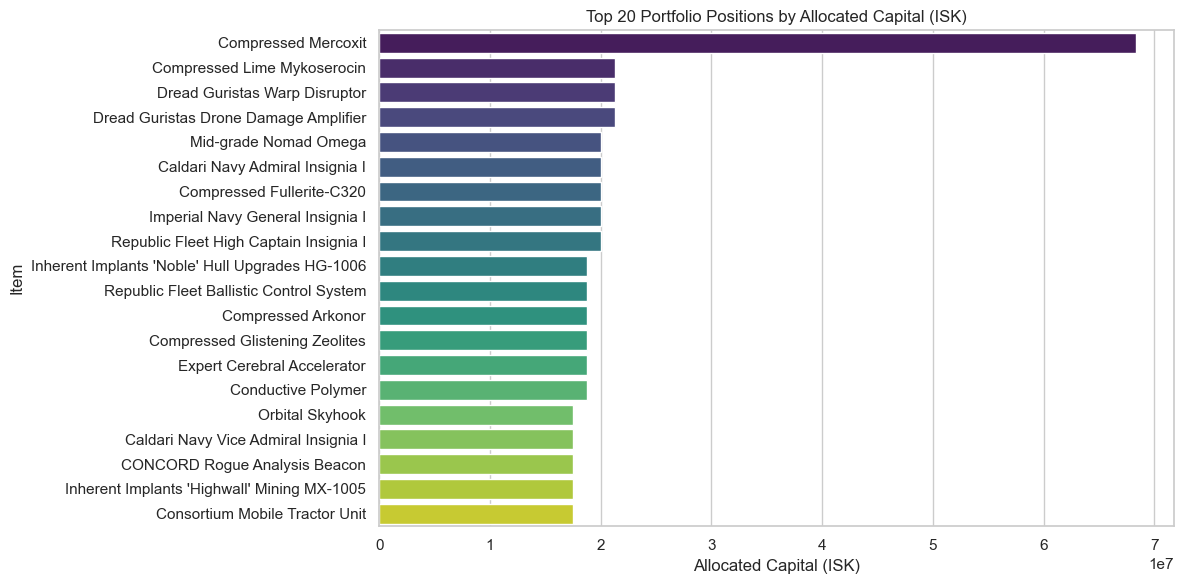

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=top20_df, x='final_alloc_value', y='Item', hue='Item', palette="viridis", legend=False)
plt.title('Top 20 Portfolio Positions by Allocated Capital (ISK)')
plt.xlabel('Allocated Capital (ISK)')
plt.ylabel('Item')
plt.tight_layout()
plt.show()
